# Classification with news (all) with price + text

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [529]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import copy
import sklearn
import xgboost
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from pythainlp.corpus import stopwords
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
from sklearn import tree, ensemble, svm
from sklearn import decomposition, cluster, naive_bayes, discriminant_analysis
from sklearn import pipeline, grid_search, manifold
from copy import deepcopy
from collections import Counter

% matplotlib inline

target_stocks = ['BANPU','IRPC','PTT','BBL','KBANK','SCB','AOT','THAI','CPF','MINT',
                 'TU','SCC','CPN','CK','CPALL','HMPRO','BDMS','BH','ADVANC','JAS','TRUE']

In [4]:
# df_price = pd.read_csv('merged_2013_2018.csv')
# df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
# df_price = df_price.loc[df_price['Ticker'].isin(target_stocks)]
# df_price['Date'] = df_price['Date'].dt.date
# df_price = df_price.set_index('Date')
# df_price.tail(1)
# len(df_price)

# df_kaohoon = pd.read_csv('data/kaohoon_all.csv')
# df_kaohoon['Date'] = pd.to_datetime(df_kaohoon['Date'], format='%Y-%m-%d')
# df_kaohoon = df_kaohoon.set_index('Date')
# df_kaohoon = df_kaohoon[:'2018-2-8']
# df_kaohoon.index = df_kaohoon.index.date
# df_kaohoon.tail(1)
# len(df_kaohoon)

# df_moneych = pd.read_csv('data/moneychanel_all.csv')
# df_moneych['Date'] = pd.to_datetime(df_moneych['Date'], format='%Y-%m-%d')
# df_moneych = df_moneych.set_index('Date')
# df_moneych = df_moneych[:'2018-2-8']
# df_moneych.index = df_moneych.index.date
# df_moneych.tail(1)
# len(df_moneych)

# df_news = pd.concat([df_moneych, df_kaohoon])
# 'Total:', len(df_news.index)

# Lag & Horizon Construction

In [5]:
# N_lags = 3
# N_horizon = 1

# df_train = []
# df_test = []
# df_val = []
# for stock in tqdm_notebook(target_stocks):
#     news_stocks = []
#     df_stock = df_news.loc[df_news['Ticker'] == stock]
#     prev_date = None
#     prev_text = None
    
#     pbar = tqdm_notebook(total=len(df_stock))
#     for date, row in df_stock.iterrows():
#         if prev_date == None:
#             prev_date = date
#             prev_text = row['Text']
#         elif prev_date != date:
#             # horizon
#             tmp_date = copy.deepcopy(prev_date)
#             tmp_date += timedelta(days=1)
#             prices = []
#             count_lags = 0 
#             while count_lags < N_horizon:
#                 price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
#                 tmp_date += timedelta(days=1)
#                 if len(price) == 0: continue
#                 prices.append(price[0][4]) # Close price next day(s)
#                 count_lags+=1
            
#             # lag
#             tmp_date = copy.deepcopy(prev_date)
#             count_lags = 0 
#             while count_lags < N_lags:
#                 price = df_price.loc[(df_price.index == tmp_date) & (df_price['Ticker'] == stock)].values
#                 tmp_date -= timedelta(days=1)
#                 if len(price) == 0: continue
#                 for val in price[0][:-1]: 
#                     if type(val) != str: prices.append(val)
#                 count_lags+=1

#             news_stocks.append([prev_date, stock, prev_text] + prices)
            
#             prev_date = date
#             prev_text = row['Text']
#         elif prev_date == date:
#             prev_text += ' '+row['Text']
        
#         pbar.update(1)
#     pbar.close()

#     news_stocks = pd.DataFrame.from_records(news_stocks)
#     news_stocks.columns = ['Date', 'Ticker', 'Text', 
#                            'Close(t+1)', # 'Close(t+2)','Close(t+3)','Close(t+4)','Close(t+5)',
#                            'Open(t)', 'High(t)', 'Low(t)', 'Close(t)',
#                            'Open(t-1)', 'High(t-1)', 'Low(t-1)', 'Close(t-1)',
#                            'Open(t-2)', 'High(t-2)', 'Low(t-2)', 'Close(t-2)',
# #                            'Open(t-3)', 'High(t-3)', 'Low(t-3)', 'Close(t-3)',
# #                            'Open(t-4)', 'High(t-4)', 'Low(t-4)', 'Close(t-4)',
# #                            'Open(t-5)', 'High(t-5)', 'Low(t-5)', 'Close(t-5)'
#                           ]
#     news_stocks = news_stocks.set_index('Date')
    
#     train_size = int(len(news_stocks) * 0.80)
#     test_size = int(len(news_stocks) * 0.10)
    
#     train = news_stocks.iloc[:train_size]
#     test = news_stocks.iloc[train_size: train_size + test_size]
#     val = news_stocks.iloc[train_size + test_size: ]

#     print(stock, ':\t',len(train), len(test), len(val))    
#     df_train.append(train)
#     df_test.append(test)
#     df_val.append(val)


# df_train = pd.concat(df_train, axis=0)
# df_test = pd.concat(df_test, axis=0)
# df_val = pd.concat(df_val, axis=0)

# len(df_train), len(df_test), len(df_val) 
# df_train.head(1)
# df_test.head(1)
# df_val.head(1)

In [6]:
# df_train.to_csv('data/df_train_news.csv')
# df_test.to_csv('data/df_test_news.csv')
# df_val.to_csv('data/df_val_news.csv')

In [7]:
df_train = pd.read_csv('data/df_train_news.csv')
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_train = df_train.set_index('Date')

df_test = pd.read_csv('data/df_test_news.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')
df_test = df_test.set_index('Date')

df_val = pd.read_csv('data/df_val_news.csv')
df_val['Date'] = pd.to_datetime(df_val['Date'], format='%Y-%m-%d')
df_val = df_val.set_index('Date')

df_train = df_train[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]
df_test = df_test[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]
df_val = df_val[['Ticker', 'Text', 'Close(t+1)', 'Close(t)', 'Close(t-1)', 'Close(t-2)']]

In [8]:
def generate_target_class(df_tmp):
    df_tmp['changes'] = df_tmp['Close(t+1)'] - df_tmp['Close(t)']
    df_tmp['class'] = np.where(df_tmp['changes']>=0, 1, 0)
    df_tmp = df_tmp.drop(['Close(t+1)', 'changes'], axis=1)
    return df_tmp

df_train = generate_target_class(df_train)
df_test = generate_target_class(df_test)
df_val = generate_target_class(df_val)

df_train.shape
df_test.shape
df_val.shape

(20466, 6)

(2549, 6)

(2577, 6)

# TF-IDF Vetorization

In [9]:
# Thai shtopwords
stop_words = stopwords.words('thai')
stop_words.remove('ขึ้น')
stop_words.remove('ลง')

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words

**min_df** is used for removing terms that appear too infrequently

In [14]:
vertorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    stop_words=stop_words,
    max_df=0.50,  
    min_df=0.03,
)

In [15]:
tfidf_train = vertorizer.fit_transform(df_train['Text'])
tfidf_test = vertorizer.transform(df_test['Text'])
tfidf_val = vertorizer.transform(df_val['Text'])

df_tfidf_train = pd.DataFrame.from_records(tfidf_train.toarray())
df_tfidf_test = pd.DataFrame.from_records(tfidf_test.toarray())
df_tfidf_val = pd.DataFrame.from_records(tfidf_val.toarray())

df_tfidf_train = df_tfidf_train.set_index(df_train.index)
df_tfidf_test = df_tfidf_test.set_index(df_test.index)
df_tfidf_val = df_tfidf_val.set_index(df_val.index)

df_tfidf_train.shape, df_tfidf_test.shape, df_tfidf_val.shape

# replace Text with TF-IDF vector
x_train = df_train.drop(['Text'], axis=1)
x_test = df_test.drop(['Text'], axis=1)
x_val = df_val.drop(['Text'], axis=1)

x_train = pd.concat([x_train, df_tfidf_train], axis=1)
x_test = pd.concat([x_test, df_tfidf_test], axis=1)
x_val = pd.concat([x_val, df_tfidf_val], axis=1)

# Label Encoding
le = sklearn.preprocessing.LabelEncoder()
x_train['Ticker'] = le.fit_transform(x_train['Ticker'])
x_test['Ticker'] = le.transform(x_test['Ticker'])
x_val['Ticker'] = le.transform(x_val['Ticker'])
x_train.head(1)
# le.classes_

((20466, 1019), (2549, 1019), (2577, 1019))

,Ticker,Close(t),Close(t-1),Close(t-2),class,0,1,2,3,4,...,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-03,2,25.5,24.3,24.3,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.080439,0.0,0.0,0.0,0.0,0.0


# Create x_train and y_train

In [16]:
Horizon = 'class'
y_train = x_train[[Horizon]]
x_train = x_train.drop([Horizon], axis=1).copy()
x_train.shape, y_train.shape

y_val = x_val[[Horizon]]
x_val = x_val.drop([Horizon], axis=1).copy()
x_val.shape, y_val.shape

((20466, 1023), (20466, 1))

((2577, 1023), (2577, 1))

## Feature Selection

In [90]:
# sel = sklearn.feature_selection.VarianceThreshold(threshold=(.999 * (1 - .999)))
# sel.fit_transform(x_train).shape

# sel = sklearn.feature_selection.SelectFromModel(regr, prefit=True)
# x_new = sel.transform(x_train)
# x_new

## Unsupervised Dimensionality reduction

### Feature Agglomeration

In [505]:
ward = sklearn.cluster.FeatureAgglomeration(n_clusters=3)
ward.fit(x_train)

FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=None, linkage='ward', memory=None, n_clusters=3,
           pooling_func=<function mean at 0x7fd5ebb2b598>)

### Principal Component Analysis 

In [506]:
pca = sklearn.decomposition.PCA(5, random_state=100)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=100,
  svd_solver='auto', tol=0.0, whiten=False)

In [507]:
sel_x_train = pca.transform(x_train)
sel_x_train.shape

(20466, 5)

## Supervised Dimensionality reduction


### Linear Discriminant Analysis

In [144]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
lda.fit_transform(x_train, np.squeeze(y_train.values)).shape

(20466, 1)

## Apply reduction

In [547]:
# sel_x_train = np.concatenate((ward.transform(x_train), pca.transform(x_train)), axis=1)
# sel_x_val = np.concatenate((ward.transform(x_val), pca.transform(x_val)), axis=1)

# sel_x_train = ward.transform(x_train)
# sel_x_val = ward.transform(x_val)

sel_x_train = pca.transform(x_train)
sel_x_val = pca.transform(x_val)

# sel_x_train = deepcopy(x_train)
# sel_x_val = deepcopy(x_val)
# 
sel_x_train.shape, sel_x_val.shape

((20466, 5), (2577, 5))

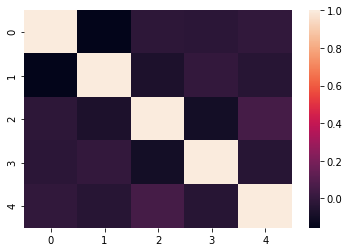

In [548]:
sns.heatmap(pd.DataFrame.from_records(sel_x_val).corr())

# Linear Regression

In [551]:
regr = sklearn.linear_model.LogisticRegression()
regr.fit(sel_x_train, np.squeeze(y_train.values))

evaluator(regr, x_test, le, ward=None, pca=pca)

Counter(regr.predict(sel_x_train))
Counter(regr.predict(sel_x_val))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.56
BBL 	acc: 0.68
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.57
SCC 	acc: 0.55
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.70
ADVANC 	acc: 0.58
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6089


Counter({0: 265, 1: 20201})

Counter({0: 18, 1: 2559})

# Decistion Tree Regressor

In [552]:
param_dt = {
    'criterion':['entropy'],
    'max_depth':[6,7,8],
    'max_features':[0.6,0.7,0.8,None],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3,4],
    'random_state': [100]
}
grids = grid_search.ParameterGrid(param_dt)

max_acc = -1
best_param = {}
dt = None
for param in tqdm_notebook(grids):
    model = tree.DecisionTreeClassifier(**param)
    _=model.fit(sel_x_train, y_train)
    acc = sklearn.metrics.accuracy_score(y_val.values, model.predict(sel_x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        dt = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
dt
evaluator(dt, x_test, le, ward=None, pca=pca)

Counter(dt.predict(sel_x_val))

HBox(children=(IntProgress(value=0, max=108), HTML(value='')))


val_acc: 59.91 %


{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 0.6,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 100}

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.56
BBL 	acc: 0.52
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.60
SCC 	acc: 0.52
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.63
ADVANC 	acc: 0.68
JAS 	acc: 0.52
TRUE 	acc: 0.53
mean Accuracy: 0.6012


Counter({0: 229, 1: 2348})

# Random Forest Regrssor

In [554]:
grids = sklearn.grid_search.ParameterGrid({
    'criterion':['entropy'],
    'max_depth':[4,6,8,10],
#     'max_features':[0.7,0.8,0.9,None],
#     'min_samples_leaf':[1,2,3],
#     'min_samples_split':[2,3,4],
    'random_state': [100],
    'n_jobs':[8],
    'n_estimators':[4,8,12,16,20]
})

max_acc = -1
best_param = {}
rf = None
for param in tqdm_notebook(grids):
    model = ensemble.RandomForestClassifier(**param)
    _=model.fit(sel_x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(sel_x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        rf = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
rf
evaluator(rf, x_test, le, ward=None, pca=pca)
Counter(rf.predict(sel_x_val))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))


val_acc: 60.19 %


{'criterion': 'entropy',
 'max_depth': 8,
 'n_estimators': 16,
 'n_jobs': 8,
 'random_state': 100}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=8,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

BANPU 	acc: 0.58
IRPC 	acc: 0.70
PTT 	acc: 0.57
BBL 	acc: 0.67
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.59
SCC 	acc: 0.55
CPN 	acc: 0.57
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.73
ADVANC 	acc: 0.59
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6121


Counter({0: 90, 1: 2487})

# AdaBoost Regressor

In [198]:
grids = sklearn.grid_search.ParameterGrid({
    'base_estimator':[rf],
    'n_estimators':[20],
    'learning_rate':[0.3],
    'loss':['square'],
    'random_state': [100]
})

max_acc = -1
best_param = {}
ada = None
for param in tqdm_notebook(grids):
    model = ensemble.AdaBoostClassifier(**param)
    _=model.fit(sel_x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(sel_x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        ada = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
ada
evaluator(ada, x_test, le)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

1.1273315494031821

{'base_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
 'learning_rate': 0.3,
 'loss': 'square',
 'n_estimators': 20,
 'random_state': 100}

In [199]:
ada
evaluator(ada, x_test, le)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
         learning_rate=0.3, loss='square', n_estimators=20,
         random_state=100)

BANPU 	RMSE: 0.23	 MAE: 0.18 	MAPE: 1.08 	DA: 0.57
IRPC 	RMSE: 0.09	 MAE: 0.07 	MAPE: 1.23 	DA: 0.49
PTT 	RMSE: 2.87	 MAE: 2.11 	MAPE: 0.55 	DA: 0.56
BBL 	RMSE: 1.48	 MAE: 1.18 	MAPE: 0.64 	DA: 0.50
KBANK 	RMSE: 2.21	 MAE: 1.77 	MAPE: 0.89 	DA: 0.48
SCB 	RMSE: 1.43	 MAE: 1.11 	MAPE: 0.73 	DA: 0.56
AOT 	RMSE: 0.91	 MAE: 0.70 	MAPE: 1.39 	DA: 0.55
THAI 	RMSE: 0.42	 MAE: 0.31 	MAPE: 1.63 	DA: 0.56
CPF 	RMSE: 0.38	 MAE: 0.29 	MAPE: 1.13 	DA: 0.56
MINT 	RMSE: 0.52	 MAE: 0.41 	MAPE: 1.02 	DA: 0.50
TU 	RMSE: 0.28	 MAE: 0.20 	MAPE: 1.04 	DA: 0.58
SCC 	RMSE: 4.88	 MAE: 3.98 	MAPE: 0.79 	DA: 0.48
CPN 	RMSE: 1.08	 MAE: 0.85 	MAPE: 1.20 	DA: 0.58
CK 	RMSE: 0.35	 MAE: 0.28 	MAPE: 1.00 	DA: 0.46
CPALL 	RMSE: 0.62	 MAE: 0.49 	MAPE: 0.78 	DA: 0.50
HMPRO 	RMSE: 0.19	 MAE: 0.13 	MAPE: 1.20 	DA: 0.53
BDMS 	RMSE: 0.24	 MAE: 0.18 	MAPE: 0.91 	DA: 0.47
BH 	RMSE: 2.65	 MAE: 1.79 	MAPE: 0.90 	DA: 0.57
ADVANC 	RMSE: 1.92	 MAE: 1.41 	MAPE: 0.77 	DA: 0.53
JAS 	RMSE: 0.11	 MAE: 0.08 	MAPE: 1.02 	DA: 0.44
TRUE 	RM

# Gradient Boosting Regressor

In [207]:
grids = sklearn.grid_search.ParameterGrid({
    'criterion':['friedman_mse'],
    'n_estimators':[50],
    'learning_rate':[0.3],
    'max_depth':[8],
    'random_state': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
})

min_MAPE = 9999999
best_param = {}
gb = None
for param in tqdm_notebook(grids):
    model = ensemble.GradientBoostingRegressor(**param)
    _=model.fit(sel_x_train, np.squeeze(y_train.values))
    MAPE = mean_absolute_percentage_error(np.squeeze(y_val.values), model.predict(sel_x_val))
    if MAPE < min_MAPE:
        min_MAPE = deepcopy(MAPE)
        best_param = deepcopy(param)
        gb = deepcopy(model)
min_MAPE
best_param

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

1.2498595228576765

{'criterion': 'friedman_mse',
 'learning_rate': 0.3,
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50,
 'random_state': 100}

In [208]:
gb
evaluator(gb, x_test, le)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=100,
             subsample=1.0, verbose=0, warm_start=False)

BANPU 	RMSE: 0.25	 MAE: 0.20 	MAPE: 1.17 	DA: 0.53
IRPC 	RMSE: 0.13	 MAE: 0.09 	MAPE: 1.58 	DA: 0.50
PTT 	RMSE: 2.78	 MAE: 1.98 	MAPE: 0.51 	DA: 0.65
BBL 	RMSE: 1.70	 MAE: 1.35 	MAPE: 0.73 	DA: 0.55
KBANK 	RMSE: 2.28	 MAE: 1.86 	MAPE: 0.94 	DA: 0.53
SCB 	RMSE: 1.48	 MAE: 1.18 	MAPE: 0.78 	DA: 0.54
AOT 	RMSE: 0.86	 MAE: 0.62 	MAPE: 1.23 	DA: 0.61
THAI 	RMSE: 0.42	 MAE: 0.29 	MAPE: 1.55 	DA: 0.60
CPF 	RMSE: 0.39	 MAE: 0.30 	MAPE: 1.15 	DA: 0.57
MINT 	RMSE: 0.51	 MAE: 0.43 	MAPE: 1.06 	DA: 0.48
TU 	RMSE: 0.31	 MAE: 0.22 	MAPE: 1.17 	DA: 0.55
SCC 	RMSE: 5.63	 MAE: 4.41 	MAPE: 0.88 	DA: 0.52
CPN 	RMSE: 1.14	 MAE: 0.89 	MAPE: 1.26 	DA: 0.54
CK 	RMSE: 0.34	 MAE: 0.28 	MAPE: 1.00 	DA: 0.45
CPALL 	RMSE: 0.61	 MAE: 0.47 	MAPE: 0.75 	DA: 0.42
HMPRO 	RMSE: 0.22	 MAE: 0.14 	MAPE: 1.29 	DA: 0.50
BDMS 	RMSE: 0.25	 MAE: 0.19 	MAPE: 0.95 	DA: 0.45
BH 	RMSE: 2.84	 MAE: 2.01 	MAPE: 1.02 	DA: 0.53
ADVANC 	RMSE: 2.00	 MAE: 1.58 	MAPE: 0.87 	DA: 0.51
JAS 	RMSE: 0.13	 MAE: 0.09 	MAPE: 1.11 	DA: 0.50
TRUE 	RM

# XGBoost Regressor

In [302]:
sel_x_train.shape

(20466, 17)

In [321]:
d_train = xgboost.DMatrix(sel_x_train, label=y_train)
d_valid = xgboost.DMatrix(sel_x_val, label=y_val)

In [341]:
grids = sklearn.grid_search.ParameterGrid({
    'booster':['gbtree'],
    'learning_rate':[0.1],
    'max_depth':[2,3,4,5,6],
    'subsample': [1],
    'objective': ['reg:logistic','binary:logistic'],
# #     'eval_metric':['auc'],
    'nthread': [8],
#     'lambda': [0, 0.2],
#     'alpha': [0.0, 0.2],
#     'updater': ['coord_descent']
})

max_acc = -1
best_param = {}
xgb = None
for param in tqdm_notebook(grids):
    model = xgboost.train(
        param, 
        d_train, 
        num_boost_round=500, 
        evals=[(d_train, 'train'), (d_valid, 'valid')], 
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values),np.where(model.predict(d_valid)>=0.5, 1, 0))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        xgb = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
xgb
evaluator(xgb, x_test, le, isXGB=True, ward=ward, pca=pca)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


val_acc: 59.76 %


{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 4,
 'nthread': 8,
 'objective': 'reg:logistic',
 'subsample': 1}

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.56
BBL 	acc: 0.67
KBANK 	acc: 0.58
SCB 	acc: 0.62
AOT 	acc: 0.72
THAI 	acc: 0.51
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.59
SCC 	acc: 0.53
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.69
HMPRO 	acc: 0.66
BDMS 	acc: 0.61
BH 	acc: 0.69
ADVANC 	acc: 0.58
JAS 	acc: 0.52
TRUE 	acc: 0.53
mean Accuracy: 0.6047


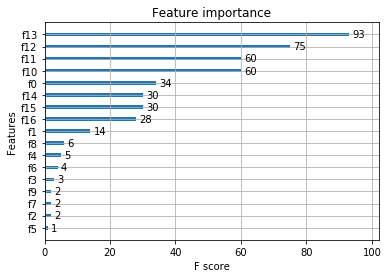

In [342]:
xgboost.plot_importance(xgb, height=0.3)

# KNeighbors

In [555]:
grids = sklearn.grid_search.ParameterGrid({
    'algorithm': ['ball_tree'],
    'weights': ['uniform'],
    'n_neighbors': [3,5,7,9,13],
#     'leaf_size': [20, 30, 40],
#     'p': [1, 2],
    'n_jobs':[-1]
})

max_acc = -1
best_param = {}
knn = None
for param in tqdm_notebook(grids):
    model = sklearn.neighbors.KNeighborsClassifier(**param)
    _=model.fit(sel_x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(sel_x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        knn = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


val_acc: 57.24 %


{'algorithm': 'ball_tree',
 'n_jobs': -1,
 'n_neighbors': 9,
 'weights': 'uniform'}

In [557]:
knn
evaluator(knn, x_test, le, ward=None, pca=pca)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

BANPU 	acc: 0.62
IRPC 	acc: 0.55
PTT 	acc: 0.50
BBL 	acc: 0.61
KBANK 	acc: 0.56
SCB 	acc: 0.57
AOT 	acc: 0.65
THAI 	acc: 0.56
CPF 	acc: 0.53
MINT 	acc: 0.51
TU 	acc: 0.65
SCC 	acc: 0.49
CPN 	acc: 0.52
CK 	acc: 0.57
CPALL 	acc: 0.54
HMPRO 	acc: 0.50
BDMS 	acc: 0.59
BH 	acc: 0.55
ADVANC 	acc: 0.58
JAS 	acc: 0.50
TRUE 	acc: 0.56
mean Accuracy: 0.5581


# Multivariate Bernoulli

In [277]:
grids = sklearn.grid_search.ParameterGrid({
    'alpha': [1.0]
})

max_acc = -1
best_param = {}
bay = None
for param in tqdm_notebook(grids):
    model = sklearn.naive_bayes.BernoulliNB(**param)
    _=model.fit(sel_x_train, np.squeeze(y_train.values))
    acc = sklearn.metrics.accuracy_score(np.squeeze(y_val.values), model.predict(sel_x_val))
    if acc > max_acc:
        max_acc = deepcopy(acc)
        best_param = deepcopy(param)
        bay = deepcopy(model)
print('val_acc:', round(max_acc*100,2),'%')
best_param
bay
evaluator(bay, x_test, le, ward=ward, pca=pca)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


val_acc: 58.98 %


{'alpha': 1.0}

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

BANPU 	acc: 0.58
IRPC 	acc: 0.69
PTT 	acc: 0.53
BBL 	acc: 0.67
KBANK 	acc: 0.58
SCB 	acc: 0.61
AOT 	acc: 0.72
THAI 	acc: 0.52
CPF 	acc: 0.59
MINT 	acc: 0.61
TU 	acc: 0.57
SCC 	acc: 0.50
CPN 	acc: 0.56
CK 	acc: 0.60
CPALL 	acc: 0.68
HMPRO 	acc: 0.66
BDMS 	acc: 0.62
BH 	acc: 0.67
ADVANC 	acc: 0.56
JAS 	acc: 0.52
TRUE 	acc: 0.55
mean Accuracy: 0.6006


# Stacking Ensemble

In [488]:
stack = np.concatenate((
    dt.predict(sel_x_val).reshape(-1,1),
    rf.predict(sel_x_val).reshape(-1,1),
#     ada.predict(sel_x_val).reshape(-1,1),
#     gb.predict(sel_x_val).reshape(-1,1),
    xgb.predict(d_valid).reshape(-1,1),
    knn.predict(sel_x_val).reshape(-1,1),
    bay.predict(sel_x_val).reshape(-1,1),
    sel_x_val
), axis=1)

stack.shape

(2577, 22)

In [489]:
for k in range(stack.shape[1]):
    sel_stack = sklearn.decomposition.PCA(k+1, random_state=100)
    sel_x_stack = sel_stack.fit_transform(stack)

    params = {
        'random_state': 100,
    }

    gb_stack = sklearn.linear_model.LogisticRegression(**params)
    _=gb_stack.fit(sel_x_stack, np.squeeze(y_val.values))

    print('acc:', k+1, round(sklearn.metrics.accuracy_score(np.squeeze(y_val.values), gb_stack.predict(sel_x_stack))*100,2))

acc: 1 59.18
acc: 2 59.18
acc: 3 59.37
acc: 4 59.37
acc: 5 59.88
acc: 6 59.88
acc: 7 59.6
acc: 8 59.57
acc: 9 59.57
acc: 10 59.95
acc: 11 59.99
acc: 12 60.15
acc: 13 60.15
acc: 14 60.15
acc: 15 60.15
acc: 16 60.19
acc: 17 60.15
acc: 18 60.15
acc: 19 60.19
acc: 20 60.15
acc: 21 60.19
acc: 22 60.19


In [490]:
sel_stack = sklearn.decomposition.PCA(10, random_state=100)
sel_x_stack = sel_stack.fit_transform(stack)

In [492]:
params = {
    'criterion':['friedman_mse'],
    'n_estimators':[10,20,30,40,50],
#     'learning_rate':[0.1],
#     'max_depth':[10,15,20,25],
#     'random_state': [100],
#     'presort':[True, False]
}

grid = sklearn.model_selection.GridSearchCV(
    ensemble.GradientBoostingClassifier(),
    params,
    n_jobs=-1
)
grid.fit(sel_x_stack, np.squeeze(y_val.values))
grid.best_score_
grid.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50], 'criterion': ['friedman_mse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

0.5785797438882422

{'criterion': 'friedman_mse', 'n_estimators': 10}

In [493]:
gb_stack = ensemble.GradientBoostingRegressor(**grid.best_params_)
gb_stack.fit(sel_x_stack, np.squeeze(y_val.values))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [497]:
models = [
    'dt',
    'rf',
#     'ada',
#     'gb',
    'xgb',
    'knn',
    'bay'
]
for model, weight in zip(models, gb_stack.feature_importances_):
    print(round(weight,4), model)

0.2291 dt
0.0819 rf
0.1997 xgb
0.1394 knn
0.1948 bay


In [496]:
    
ensemble_evaluator(
    x_test,
    ward=ward,
    pca=pca
)

BANPU 	acc: 0.42
IRPC 	acc: 0.31
PTT 	acc: 0.56
BBL 	acc: 0.68
KBANK 	acc: 0.61
SCB 	acc: 0.61
AOT 	acc: 0.28
THAI 	acc: 0.48
CPF 	acc: 0.41
MINT 	acc: 0.39
TU 	acc: 0.43
SCC 	acc: 0.52
CPN 	acc: 0.44
CK 	acc: 0.40
CPALL 	acc: 0.31
HMPRO 	acc: 0.34
BDMS 	acc: 0.38
BH 	acc: 0.70
ADVANC 	acc: 0.58
JAS 	acc: 0.48
TRUE 	acc: 0.45
mean Accuracy: 0.4658


In [495]:
def evaluator(clf, df_test, le, isXGB=False, isLSTM=False, ward=None, pca=None):
    ACCs = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        x_tmp = x_tmp.drop([Horizon], axis=1)
        
        if ward is not None and pca is not None:
            sel_x_tmp = np.concatenate((ward.transform(x_tmp.values), pca.transform(x_tmp.values)), axis=1)
        elif ward is not None:
            sel_x_tmp = ward.transform(x_tmp.values)
        elif pca is not None:
            sel_x_tmp = pca.transform(x_tmp.values)
        else:
            sel_x_tmp = deepcopy(x_tmp.values)
    
        if isXGB: 
            y_pred = clf.predict(xgboost.DMatrix(sel_x_tmp))
            y_pred = np.where(y_pred>=0.5, 1, 0)
        else: y_pred = clf.predict(sel_x_tmp)
        
        acc = sklearn.metrics.accuracy_score(y_tmp, y_pred)
        print(stock, "\tacc: %.2f" % (acc))
        ACCs.append(acc)
    
    print('mean Accuracy:', round(np.mean(ACCs),4))
    
def ensemble_evaluator(df_test, ward=None, pca=None):
    ACCs = []
    for stock in target_stocks:
        x_tmp = df_test.loc[df_test['Ticker'] == le.transform([stock])[0]].copy()
        
        y_tmp = x_tmp[Horizon].values
        x_tmp = x_tmp.drop([Horizon], axis=1)
        
        
        if ward is not None and pca is not None:
            sel_x_tmp = np.concatenate((ward.transform(x_tmp.values), pca.transform(x_tmp.values)), axis=1)
        elif ward is not None:
            sel_x_tmp = ward.transform(x_tmp.values)
        elif pca is not None:
            sel_x_tmp = pca.transform(x_tmp.values)
        else:
            sel_x_tmp = deepcopy(x_tmp.values)
        
#         y_pred = (y_dt+y_rf+y_ada+y_gb+y_xgb+y_knn+y_bay)/7

        y_stack = np.concatenate((
            dt.predict(sel_x_tmp).reshape(-1,1),
            rf.predict(sel_x_tmp).reshape(-1,1),
#             ada.predict(sel_x_tmp).reshape(-1,1),
#             gb.predict(sel_x_tmp).reshape(-1,1),
            xgb.predict(xgboost.DMatrix(sel_x_tmp)).reshape(-1,1),
            knn.predict(sel_x_tmp).reshape(-1,1),
            bay.predict(sel_x_tmp).reshape(-1,1),
            sel_x_tmp
        ), axis=1)

        sel_y_stack = sel_stack.transform(y_stack)
        y_pred = np.zeros((sel_y_stack.shape[0],1))
        for i in range(sel_y_stack.shape[1]):
            y_pred += sel_y_stack[:,i].reshape(-1,1)*gb_stack.feature_importances_[i]
        y_pred = np.squeeze(y_pred)
        y_pred = np.where(y_pred>=0.5, 1, 0)

        acc = sklearn.metrics.accuracy_score(y_tmp, y_pred)
        print(stock, "\tacc: %.2f" % (acc))
        ACCs.append(acc)
    
    print('mean Accuracy:', round(np.mean(ACCs),4))